In [1]:
import WesBotTWO as wb
import HandOddsCalcWes as hoc

import texasholdem as th
import texasholdem.evaluator as eval
import numpy as np
import pandas as pd
import random
from tqdm import trange

In [2]:
# smort_decision(our_bot:PokerBot, game:th.TexasHoldEm)
# actually make a goddamn decision using my scuffed bot thingy, and record
# all the necessary information for Shro' to use in his thing
# INPUTS:
#   our_bot: a PokerBot object, supposed to be intelligent or something
#   game:    a TexasHoldEm game object that we're playing
# OUTPUT:
#   a list containing:
#     [hand_phase:str,
#      my_hand:list of th.Card,
#      board:list of th.Card,
#      EV:float,
#      my_chips_betting:int,
#      their_chips_betting:int,
#      my_decision:Decision]
# SIDE EFFECT:
#   makes the decision in the TexasHoldEm game object passed in
def smort_decision(our_bot:wb.PokerBot, game:th.TexasHoldEm):
  # get information regarding our hand, the game board, our win prob,
  # their chips bet, and our EV
  win_prob =  hoc.estimate_win_prob(game, game.current_player, 2, 1000)
  loss_prob = 1 - win_prob
  my_chips_betting = game.player_bet_amount(0)
  their_chips_betting = game.player_bet_amount(1)
  EV = win_prob*their_chips_betting - loss_prob*(my_chips_betting + \
                                                 game.chips_to_call(0))
  # get features for Shro'
  my_decision = our_bot.make_decision(EV, game)
  my_hand = game.get_hand(game.current_player)
  board = []
  for card in game.board:
    board.append(card)
  # record hand phase
  hand_phase = game.hand_phase.name
  # actually make the decision
  if (my_decision.type == "RAISE"):
    if (game.validate_move(action = th.ActionType.RAISE,\
                           value = my_decision.size)):
      game.take_action(th.ActionType.RAISE, my_decision.size)
    else:
      game.take_action(th.ActionType.ALL_IN)
  elif (my_decision.type == "CALL/CHECK"):
    if (game.validate_move(action = th.ActionType.CALL)):
      game.take_action(th.ActionType.CALL)
    else:
      game.take_action(th.ActionType.CHECK)
  elif (my_decision.type == "FOLD"):
    game.take_action(th.ActionType.FOLD)
  else:
    game.take_action(th.ActionType.ALL_IN)
  output = [hand_phase, my_hand, board, EV, my_chips_betting, their_chips_betting, my_decision]
  return output

# baby_decision(game:th.TexasHoldEm)
# make a random decision for the opponent, just to get someone to play against
# INPUTS:
#   game: a th.TexasHoldEm object that we're playing
# SIDE EFFECT:
#   makes the random decision in the game object passed in
def baby_decision(game:th.TexasHoldEm):
  # make random decision
  if (np.random.rand() > 0.5):
    # baby gonna raise
    min_raise = int(game.get_available_moves().raise_range.start)
    max_raise = int(np.min([game.players[0].chips,
                            game.get_available_moves().raise_range.stop]))
    # make sure we only raise by some reasonable amount
    max_raise = int((3*min_raise + max_raise) // 4)
    if (max_raise - min_raise > 20):
      max_raise = min_raise + 20
    decision = \
      wb.Decision("RAISE", int(np.random.uniform(min_raise, max_raise)))
  else:
    # baby gonna call/check
    decision = wb.Decision("CALL/CHECK")
  # ensure validity of decision and actually make decision
  if (decision.type == "RAISE" and
      game.validate_move(action = th.ActionType.RAISE, value = decision.size)):
    game.take_action(th.ActionType.RAISE, decision.size)
    return -1
  elif (game.validate_move(action = th.ActionType.CALL)):
    game.take_action(th.ActionType.CALL)
    return -1
  elif (game.validate_move(action = th.ActionType.CHECK)):
    game.take_action(th.ActionType.CHECK)
    return -1
  game.take_action(th.ActionType.FOLD)
  return 0
  
      

In [3]:
epochs = 5000
our_bot = wb.PokerBot(maturity=epochs//4)

rounds_list = []

for i in trange(epochs):
  game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
  game.start_hand()
  current_round = []
  while (game.is_hand_running()):
    # branch on whose turn
    if (game.current_player == 0):
      our_decision = smort_decision(our_bot, game)
      current_round.append(our_decision)
      if (our_decision[6].type == "FOLD"):
        who_won = 1
      else:
        who_won = -1
    else:
      who_won = baby_decision(game)
    if (who_won == -1 and len(game.board) == 5):
      jerry_hand_rank = eval.evaluate(game.get_hand(0), game.board)
      tom_hand_rank = eval.evaluate(game.get_hand(1), game.board)
      who_won = int(jerry_hand_rank >= tom_hand_rank)
  # now round is done, close round and go again
  won_or_lost_chips = game._get_last_pot().amount*((-1)**who_won)
  our_bot.log_round(won_or_lost_chips)
  rounds_list.append([current_round, won_or_lost_chips])


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [34:48<00:00,  2.39it/s]  


In [4]:
outcomes = np.zeros(len(rounds_list))

for i in range(len(rounds_list)):
  outcomes[i] = rounds_list[i][1]

print("Avg. outcomes:", np.mean(outcomes))
print("Avg. win rate:", np.mean(outcomes > 0))

Avg. outcomes: -16.5362
Avg. win rate: 0.1244


In [5]:
class Node:
    def __init__(self, decision, children=None):
        self.decision = decision
        self.children = children if children else []

    def add_child(self, child_node):
        self.children.append(child_node)

class DecisionTree:
    def __init__(self, root, outcome):
        self.root = root
        self.outcome = outcome

# Create decision trees from rounds_list
decision_trees = []
for round_entry in rounds_list:
    decisions = round_entry[0]  # The list of decisions
    outcome = round_entry[1]    # The outcome (tail of the entry)

    # Build the tree structure
    root = Node(decisions[0])  # First decision as the root
    current_node = root
    for decision in decisions[1:]:
        new_node = Node(decision)
        current_node.add_child(new_node)
        current_node = new_node

    decision_trees.append(DecisionTree(root, outcome))



# Print the structure of the first tree
def print_tree(node, depth=0):
    print("  " * depth + f"Decision: {node.decision}")
    for child in node.children:
        print_tree(child, depth + 1)


print_tree(decision_trees[0].root)
print("Outcome:", decision_trees[0].outcome)

Decision: ['PREFLOP', [Card("Ad"), Card("8h")], [], np.float64(4.283999999999999), 5, 18, <WesBotTWO.Decision object at 0x000001EA701A5970>]
  Decision: ['FLOP', [Card("Ad"), Card("8h")], [Card("2d"), Card("4c"), Card("9s")], np.float64(0.0), 0, 0, <WesBotTWO.Decision object at 0x000001EA6F8365A0>]
    Decision: ['FLOP', [Card("Ad"), Card("8h")], [Card("2d"), Card("4c"), Card("9s")], np.float64(2.3000000000000007), 0, 23, <WesBotTWO.Decision object at 0x000001EA6F722ED0>]
      Decision: ['TURN', [Card("Ad"), Card("8h")], [Card("2d"), Card("4c"), Card("9s"), Card("Qc")], np.float64(0.0), 0, 0, <WesBotTWO.Decision object at 0x000001EA70335F70>]
        Decision: ['TURN', [Card("Ad"), Card("8h")], [Card("2d"), Card("4c"), Card("9s"), Card("Qc")], np.float64(-3.6800000000000015), 0, 23, <WesBotTWO.Decision object at 0x000001EA713D70E0>]
          Decision: ['TURN', [Card("Ad"), Card("8h")], [Card("2d"), Card("4c"), Card("9s"), Card("Qc")], np.float64(-9.504000000000005), 53, 88, <WesBotTW

In [13]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces, Env  # Use gymnasium instead of gym
import numpy as np

# Define a custom environment for decision trees
class DecisionTreeEnv(Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, decision_trees):
        self.decision_trees = decision_trees
        self.current_tree_idx = 0
        self.current_node = None
        self.action_space = spaces.Discrete(3)  # Example: 3 actions (RAISE, CALL, FOLD)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure compatibility with gymnasium
        self.current_tree_idx = np.random.randint(len(self.decision_trees))
        self.current_node = self.decision_trees[self.current_tree_idx].root
        return self._get_observation(), {}

    def step(self, action):
        # Map action to decision
        if action == 0:
            decision = "RAISE"
        elif action == 1:
            decision = "CALL/CHECK"
        else:
            decision = "FOLD"

        info = {}  # Additional information can be added here
        reward = self.decision_trees[self.current_tree_idx].outcome
        done = True  # End after one decision for simplicity
        return self._get_observation(), reward, done, {"decision": decision}, info

    def _get_observation(self):
        # Convert the current node's decision into a numerical observation
        hand_phase = self.current_node.decision[0]
        my_hand = self.current_node.decision[1]
        board = self.current_node.decision[2]
        EV = self.current_node.decision[3]
        my_chips_betting = self.current_node.decision[4]
        their_chips_betting = self.current_node.decision[5]
        decision_type = self.current_node.decision[6].type

        # Map hand_phase and decision_type to numerical values
        hand_phase_map = {"PREFLOP": 0, "FLOP": 1, "TURN": 2, "RIVER": 3}
        decision_type_map = {"RAISE": 0, "CALL/CHECK": 1, "FOLD": 2}

        hand_phase_num = hand_phase_map.get(hand_phase, -1)
        decision_type_num = decision_type_map.get(decision_type, -1)

        # Create the observation array
        return np.array([
            hand_phase_num,
            len(my_hand),  # Number of cards in hand
            len(board),    # Number of cards on the board
            EV,
            my_chips_betting,
            their_chips_betting,
            decision_type_num
        ], dtype=np.float32)

# Wrap the environment
env = DummyVecEnv([lambda: DecisionTreeEnv(decision_trees)])

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=100000)

# Save the model
model.save("ppo_decision_tree_model")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1863 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1310        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009549456 |
|    clip_fraction        | 0.0918      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.000114   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.2e+04     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00595    |
|    value_loss           | 3.1e+04     |
-----------------------------------------
-----------------

Simulating games: 100%|██████████| 1000/1000 [07:04<00:00,  2.36it/s]

PPO Bot Total Earnings: 17347
SMORT Bot Total Earnings: 113886.0


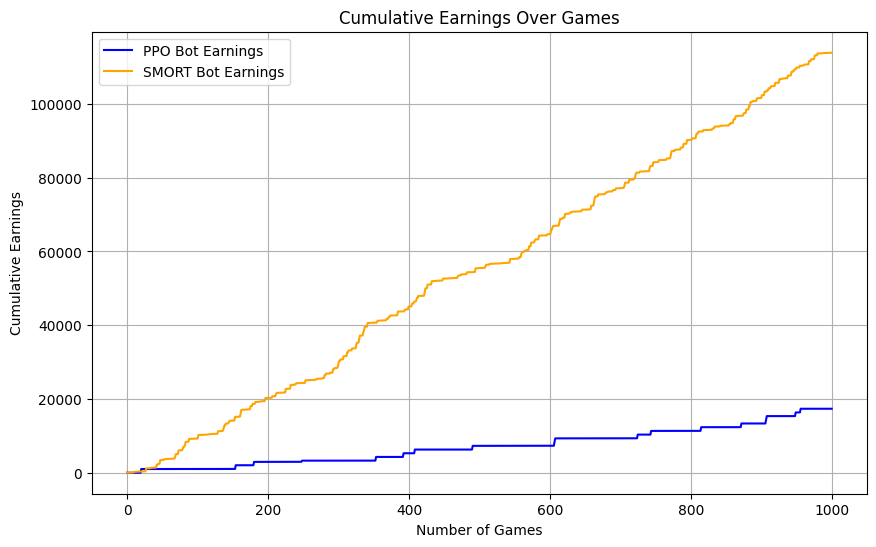

In [14]:
from tqdm import tqdm
from matplotlib import pyplot as plt
# Define the total number of games to simulate
total_games = 1000

# Reset metrics
ppo_bot_earnings = 0
ppo_cumulative_earnings = []

smort_bot_earnings = 0
smort_cumulative_earnings = []
smort_bot_decisions = []

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            smort_bot_decisions.append(smort_decision_result)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # PPO bot wins
            else:
                who_won = -1
        else:  # PPO bot's turn
            obs = env.reset()
            action, _ = model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[0].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                # Ensure CHECK is only attempted when valid
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        jerry_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        tom_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        who_won = int(jerry_hand_rank >= tom_hand_rank)

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount * ((-1) ** who_won)
    if who_won == 0:
        ppo_bot_earnings += won_or_lost_chips
    else:
        smort_bot_earnings += -won_or_lost_chips

    # Update cumulative earnings
    ppo_cumulative_earnings.append(ppo_bot_earnings)
    smort_cumulative_earnings.append(smort_bot_earnings)

# Print metrics
print("PPO Bot Total Earnings:", ppo_bot_earnings)
print("SMORT Bot Total Earnings:", smort_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), ppo_cumulative_earnings, label="PPO Bot Earnings", color="blue")
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from stable_baselines3 import A2C

# Define a custom environment for the 4th bot
class FourthBotEnv(Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, opponent_bot, decision_trees):
        self.opponent_bot = opponent_bot
        self.decision_trees = decision_trees
        self.current_tree_idx = 0
        self.current_node = None
        self.action_space = spaces.Discrete(3)  # Example: 3 actions (RAISE, CALL, FOLD)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure compatibility with gymnasium
        self.current_tree_idx = np.random.randint(len(self.decision_trees))
        self.current_node = self.decision_trees[self.current_tree_idx].root
        return self._get_observation(), {}

    def step(self, action):
        # Map action to decision
        if action == 0:
            decision = "RAISE"
        elif action == 1:
            decision = "CALL/CHECK"
        else:
            decision = "FOLD"

        # Calculate reward based on the outcome
        info = {}  # Additional information can be added here
        reward = self.decision_trees[self.current_tree_idx].outcome
        done = True  # End after one decision for simplicity
        return self._get_observation(), reward, done, {"decision": decision}, info

    def _get_observation(self):
        # Convert the current node's decision into a numerical observation
        hand_phase = self.current_node.decision[0]
        my_hand = self.current_node.decision[1]
        board = self.current_node.decision[2]
        EV = self.current_node.decision[3]
        my_chips_betting = self.current_node.decision[4]
        their_chips_betting = self.current_node.decision[5]
        decision_type = self.current_node.decision[6].type

        # Map hand_phase and decision_type to numerical values
        hand_phase_map = {"PREFLOP": 0, "FLOP": 1, "TURN": 2, "RIVER": 3}
        decision_type_map = {"RAISE": 0, "CALL/CHECK": 1, "FOLD": 2}

        hand_phase_num = hand_phase_map.get(hand_phase, -1)
        decision_type_num = decision_type_map.get(decision_type, -1)

        # Create the observation array
        return np.array([
            hand_phase_num,
            len(my_hand),  # Number of cards in hand
            len(board),    # Number of cards on the board
            EV,
            my_chips_betting,
            their_chips_betting,
            decision_type_num
        ], dtype=np.float32)

# Train the 4th bot against SMORT bot
fourth_bot_env = DummyVecEnv([lambda: FourthBotEnv(our_bot, decision_trees)])
fourth_bot_model = A2C("MlpPolicy", fourth_bot_env, verbose=1)

# Train the model
fourth_bot_model.learn(total_timesteps=100000)

# Save the model
fourth_bot_model.save("a2c_fourth_bot_model")

Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 585       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.05     |
|    explained_variance | -0.000954 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 143       |
|    value_loss         | 5.31e+04  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 603      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.56    |
|    explained_variance | 0.0848   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.535    |
|    va

Simulating games:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating games: 100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s]

SMORT Bot Total Earnings: 57224
PPO Bot Total Earnings: -613313
Fourth Bot Total Earnings: 17597.0


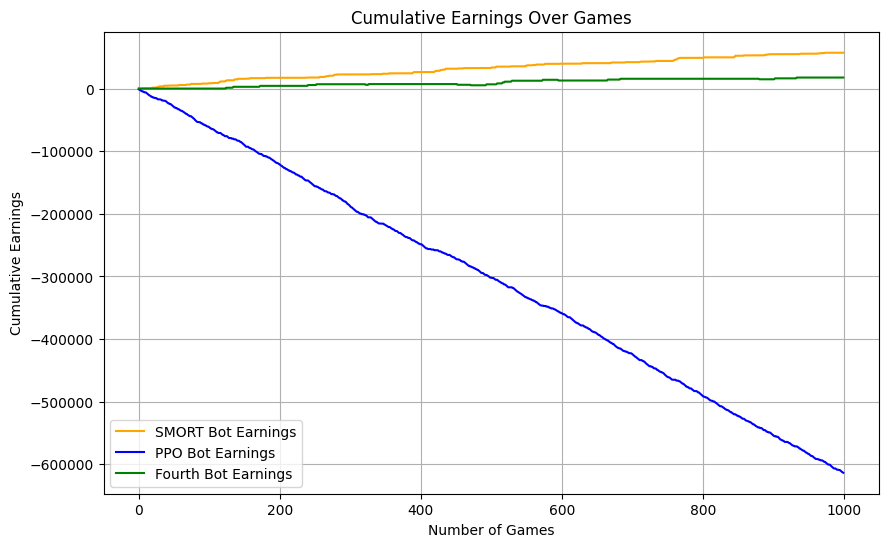

In [37]:
# Reset metrics
smort_bot_earnings = 0
ppo_bot_earnings = 0
fourth_bot_earnings = 0

smort_cumulative_earnings = []
ppo_cumulative_earnings = []
fourth_cumulative_earnings = []

total_games = 1000

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=3)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # PPO bot wins
            else:
                who_won = -1
        elif game.current_player == 1:  # PPO bot's turn
            obs = env.reset()
            action, _ = model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[1].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)
        else:  # Fourth bot's turn
            obs = fourth_bot_env.reset()
            action, _ = fourth_bot_model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[2].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        smort_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        ppo_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        fourth_hand_rank = eval.evaluate(game.get_hand(2), game.board)
        who_won = np.argmax([smort_hand_rank, ppo_hand_rank, fourth_hand_rank])

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount * ((-1) ** who_won)
    if who_won == 0:
        smort_bot_earnings += won_or_lost_chips
    elif who_won == 1:
        ppo_bot_earnings += won_or_lost_chips
    else:
        fourth_bot_earnings += won_or_lost_chips

    # Update cumulative earnings
    smort_cumulative_earnings.append(smort_bot_earnings)
    ppo_cumulative_earnings.append(ppo_bot_earnings)
    fourth_cumulative_earnings.append(fourth_bot_earnings)

# Print metrics
print("SMORT Bot Total Earnings:", smort_bot_earnings)
print("PPO Bot Total Earnings:", ppo_bot_earnings)
print("Fourth Bot Total Earnings:", fourth_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.plot(range(total_games), ppo_cumulative_earnings, label="PPO Bot Earnings", color="blue")
plt.plot(range(total_games), fourth_cumulative_earnings, label="Fourth Bot Earnings", color="green")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()

In [55]:
from stable_baselines3 import A2C

# Define a custom environment for the 5th bot
class FifthBotEnv(Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, game):
        self.game = game
        self.action_space = spaces.Discrete(3)  # Example: 3 actions (RAISE, CALL, FOLD)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure compatibility with gymnasium
        # Reinitialize the game if it is not already initialized or if no hand is running
        if not hasattr(self, 'game') or not self.game.is_hand_running():
            self.game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)  # Reinitialize the game
            self.game.start_hand()  # Start a new hand in the game
        return self._get_observation(), {}

    def step(self, action):
        # Map action to decision
        if action == 0:
            decision = (th.ActionType.RAISE, self._get_raise_amount())
        elif action == 1:
            decision = (th.ActionType.CALL, None)
        else:
            decision = (th.ActionType.FOLD, None)

        # Execute the decision
        if decision[0] == th.ActionType.RAISE and self.game.validate_move(action=decision[0], value=decision[1]):
            self.game.take_action(decision[0], decision[1])
        elif decision[0] == th.ActionType.CALL and self.game.validate_move(action=decision[0]):
            self.game.take_action(decision[0])
        elif decision[0] == th.ActionType.FOLD:
            self.game.take_action(decision[0])
        else:
            if self.game.validate_move(action=th.ActionType.CHECK):
                self.game.take_action(th.ActionType.CHECK)
            else:
                self.game.take_action(th.ActionType.FOLD)

        # Calculate reward and determine if the game is done
        info = {}  # Additional information can be added here
        reward = self.game._get_last_pot().amount * ((-1) ** self.game.current_player)
        done = not self.game.is_hand_running()
        return self._get_observation(), reward, done, {}, info

    def _get_observation(self):
        # Extract relevant game state information
        hand_phase = self.game.hand_phase.name
        my_hand = self.game.get_hand(self.game.current_player)
        board = self.game.board
        EV = hoc.estimate_win_prob(self.game, self.game.current_player, 2, 1000)
        my_chips_betting = self.game.player_bet_amount(self.game.current_player)
        their_chips_betting = self.game.player_bet_amount(1 - self.game.current_player)

        # Map hand_phase to numerical values
        hand_phase_map = {"PREFLOP": 0, "FLOP": 1, "TURN": 2, "RIVER": 3}
        hand_phase_num = hand_phase_map.get(hand_phase, -1)

        # Create the observation array
        return np.array([
            hand_phase_num,
            len(my_hand),  # Number of cards in hand
            len(board),    # Number of cards on the board
            EV,
            my_chips_betting,
            their_chips_betting,
            0  # Placeholder for decision type (not needed here)
        ], dtype=np.float32)

    def _get_raise_amount(self):
        min_raise = int(self.game.get_available_moves().raise_range.start)
        max_raise = int(np.min([self.game.players[self.game.current_player].chips,
                                self.game.get_available_moves().raise_range.stop]))
        return int(min_raise + (max_raise - min_raise) // 2)  # Example: mid-point raise

# Train the 5th bot against SMORT bot
fifth_bot_env = DummyVecEnv([lambda: FifthBotEnv(game)])
fifth_bot_model = A2C("MlpPolicy", fifth_bot_env, verbose=1)

# Train the model
fifth_bot_model.learn(total_timesteps=10000)

# Save the model
fifth_bot_model.save("a2c_fifth_bot_model")

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 8        |
|    iterations         | 100      |
|    time_elapsed       | 60       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.895   |
|    explained_variance | -0.00101 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -29      |
|    value_loss         | 2.08e+05 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 8         |
|    iterations         | 200       |
|    time_elapsed       | 119       |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -1.08     |
|    explained_variance | -0.000992 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | -54.1     |
|    valu

Simulating games: 100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s]


SMORT Bot Total Earnings: 334999
PPO Bot Total Earnings: -319709
Fourth Bot Total Earnings: 17153
Fifth Bot Total Earnings: -9445.0


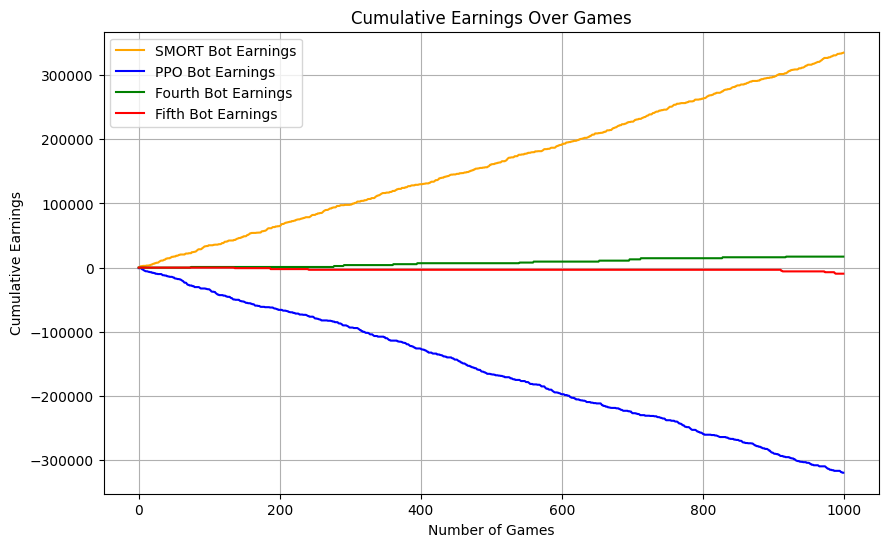

In [56]:
# Reset metrics
fifth_bot_earnings = 0
smort_bot_earnings = 0
ppo_bot_earnings = 0
fourth_bot_earnings = 0

fifth_cumulative_earnings = []
smort_cumulative_earnings = []
ppo_cumulative_earnings = []
fourth_cumulative_earnings = []

total_games = 1000

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=4)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # PPO bot wins
            else:
                who_won = -1
        elif game.current_player == 1:  # PPO bot's turn
            obs = env.reset()
            action, _ = model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[1].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)
        elif game.current_player == 2:  # Fourth bot's turn
            obs = fourth_bot_env.reset()
            action, _ = fourth_bot_model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[2].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)
        else:  # Fifth bot's turn
            obs = fifth_bot_vs_smort_env.reset()
            action, _ = fifth_bot_vs_smort_model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[3].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        smort_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        ppo_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        fourth_hand_rank = eval.evaluate(game.get_hand(2), game.board)
        fifth_hand_rank = eval.evaluate(game.get_hand(3), game.board)
        who_won = np.argmax([smort_hand_rank, ppo_hand_rank, fourth_hand_rank, fifth_hand_rank])

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount * ((-1) ** who_won)
    if who_won == 0:
        smort_bot_earnings += won_or_lost_chips
    elif who_won == 1:
        ppo_bot_earnings += won_or_lost_chips
    elif who_won == 2:
        fourth_bot_earnings += won_or_lost_chips
    else:
        fifth_bot_earnings += won_or_lost_chips

    # Update cumulative earnings
    smort_cumulative_earnings.append(smort_bot_earnings)
    ppo_cumulative_earnings.append(ppo_bot_earnings)
    fourth_cumulative_earnings.append(fourth_bot_earnings)
    fifth_cumulative_earnings.append(fifth_bot_earnings)

# Print metrics
print("SMORT Bot Total Earnings:", smort_bot_earnings)
print("PPO Bot Total Earnings:", ppo_bot_earnings)
print("Fourth Bot Total Earnings:", fourth_bot_earnings)
print("Fifth Bot Total Earnings:", fifth_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.plot(range(total_games), ppo_cumulative_earnings, label="PPO Bot Earnings", color="blue")
plt.plot(range(total_games), fourth_cumulative_earnings, label="Fourth Bot Earnings", color="green")
plt.plot(range(total_games), fifth_cumulative_earnings, label="Fifth Bot Earnings", color="red")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()

In [58]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces, Env
import numpy as np

# Define a custom environment for the 6th bot
class SixthBotEnv(Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, smort_bot, game):
        self.smort_bot = smort_bot
        self.game = game
        self.action_space = spaces.Discrete(3)  # Example: 3 actions (RAISE, CALL, FOLD)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure compatibility with gymnasium
        self.game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
        self.game.start_hand()
        return self._get_observation(), {}

    def step(self, action):
        # Map action to decision
        if action == 0:
            decision = (th.ActionType.RAISE, self._get_raise_amount())
        elif action == 1:
            decision = (th.ActionType.CALL, None)
        else:
            decision = (th.ActionType.FOLD, None)

        # Execute the decision
        if decision[0] == th.ActionType.RAISE and self.game.validate_move(action=decision[0], value=decision[1]):
            self.game.take_action(decision[0], decision[1])
        elif decision[0] == th.ActionType.CALL and self.game.validate_move(action=decision[0]):
            self.game.take_action(decision[0])
        elif decision[0] == th.ActionType.FOLD:
            self.game.take_action(decision[0])
        else:
            if self.game.validate_move(action=th.ActionType.CHECK):
                self.game.take_action(th.ActionType.CHECK)
            else:
                self.game.take_action(th.ActionType.FOLD)

        # SMORT bot's turn
        if self.game.is_hand_running():
            smort_decision(self.smort_bot, self.game)

        # Calculate reward and determine if the game is done
        reward = self.game._get_last_pot().amount * ((-1) ** self.game.current_player)
        done = not self.game.is_hand_running()
        return self._get_observation(), reward, done, {}, {}

    def _get_observation(self):
        # Extract relevant game state information
        hand_phase = self.game.hand_phase.name
        my_hand = self.game.get_hand(self.game.current_player)
        board = self.game.board
        EV = hoc.estimate_win_prob(self.game, self.game.current_player, 2, 1000)
        my_chips_betting = self.game.player_bet_amount(self.game.current_player)
        their_chips_betting = self.game.player_bet_amount(1 - self.game.current_player)

        # Map hand_phase to numerical values
        hand_phase_map = {"PREFLOP": 0, "FLOP": 1, "TURN": 2, "RIVER": 3}
        hand_phase_num = hand_phase_map.get(hand_phase, -1)

        # Create the observation array
        return np.array([
            hand_phase_num,
            len(my_hand),  # Number of cards in hand
            len(board),    # Number of cards on the board
            EV,
            my_chips_betting,
            their_chips_betting,
            0  # Placeholder for decision type (not needed here)
        ], dtype=np.float32)

    def _get_raise_amount(self):
        min_raise = int(self.game.get_available_moves().raise_range.start)
        max_raise = int(np.min([self.game.players[self.game.current_player].chips,
                                self.game.get_available_moves().raise_range.stop]))
        return int(min_raise + (max_raise - min_raise) // 2)  # Example: mid-point raise

# Train the 6th bot against SMORT bot
sixth_bot_env = DummyVecEnv([lambda: SixthBotEnv(our_bot, game)])
sixth_bot_model = PPO("MlpPolicy", sixth_bot_env, verbose=1)

# Train the model
sixth_bot_model.learn(total_timesteps=1000)

# Save the model
sixth_bot_model.save("ppo_sixth_bot_model")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2    |
|    iterations      | 1    |
|    time_elapsed    | 916  |
|    total_timesteps | 2048 |
-----------------------------


Simulating games: 100%|██████████| 1000/1000 [08:54<00:00,  1.87it/s]

SMORT Bot Total Earnings: 482505
PPO Bot Total Earnings: -227486
Fourth Bot Total Earnings: 7432
Fifth Bot Total Earnings: -8431
Sixth Bot Total Earnings: 2176.0


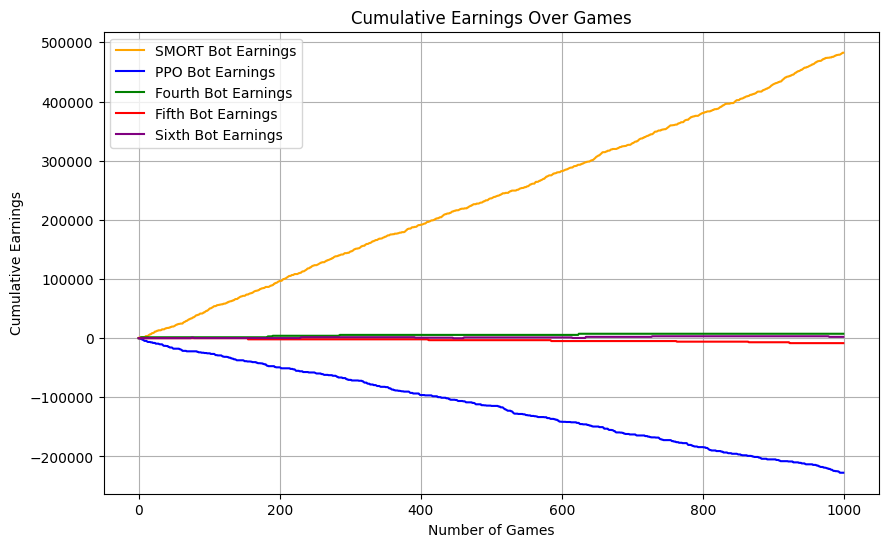

In [59]:
# Reset metrics
smort_bot_earnings = 0
ppo_bot_earnings = 0
fourth_bot_earnings = 0
fifth_bot_earnings = 0
sixth_bot_earnings = 0

smort_cumulative_earnings = []
ppo_cumulative_earnings = []
fourth_cumulative_earnings = []
fifth_cumulative_earnings = []
sixth_cumulative_earnings = []

total_games = 1000

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=5)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # PPO bot wins
            else:
                who_won = -1
        elif game.current_player == 1:  # PPO bot's turn
            obs = env.reset()
            action, _ = model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[1].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)
        elif game.current_player == 2:  # Fourth bot's turn
            obs = fourth_bot_env.reset()
            action, _ = fourth_bot_model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[2].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)
        elif game.current_player == 3:  # Fifth bot's turn
            obs = fifth_bot_env.reset()
            action, _ = fifth_bot_model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[3].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)
        else:  # Sixth bot's turn
            obs = sixth_bot_env.reset()
            action, _ = sixth_bot_model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[4].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        smort_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        ppo_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        fourth_hand_rank = eval.evaluate(game.get_hand(2), game.board)
        fifth_hand_rank = eval.evaluate(game.get_hand(3), game.board)
        sixth_hand_rank = eval.evaluate(game.get_hand(4), game.board)
        who_won = np.argmax([smort_hand_rank, ppo_hand_rank, fourth_hand_rank, fifth_hand_rank, sixth_hand_rank])

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount * ((-1) ** who_won)
    if who_won == 0:
        smort_bot_earnings += won_or_lost_chips
    elif who_won == 1:
        ppo_bot_earnings += won_or_lost_chips
    elif who_won == 2:
        fourth_bot_earnings += won_or_lost_chips
    elif who_won == 3:
        fifth_bot_earnings += won_or_lost_chips
    else:
        sixth_bot_earnings += won_or_lost_chips

    # Update cumulative earnings
    smort_cumulative_earnings.append(smort_bot_earnings)
    ppo_cumulative_earnings.append(ppo_bot_earnings)
    fourth_cumulative_earnings.append(fourth_bot_earnings)
    fifth_cumulative_earnings.append(fifth_bot_earnings)
    sixth_cumulative_earnings.append(sixth_bot_earnings)

# Print metrics
print("SMORT Bot Total Earnings:", smort_bot_earnings)
print("PPO Bot Total Earnings:", ppo_bot_earnings)
print("Fourth Bot Total Earnings:", fourth_bot_earnings)
print("Fifth Bot Total Earnings:", fifth_bot_earnings)
print("Sixth Bot Total Earnings:", sixth_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.plot(range(total_games), ppo_cumulative_earnings, label="PPO Bot Earnings", color="blue")
plt.plot(range(total_games), fourth_cumulative_earnings, label="Fourth Bot Earnings", color="green")
plt.plot(range(total_games), fifth_cumulative_earnings, label="Fifth Bot Earnings", color="red")
plt.plot(range(total_games), sixth_cumulative_earnings, label="Sixth Bot Earnings", color="purple")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()